# Life Expectancy Analysis

## 1. Introduction

In this notebook, we will analyze and explore the evolution of life expectancy (for both female and male) at both regional and country levels, from 1960 to the most recent available year. Our objective is to identify trends, gender gaps, and geographical patterns that may help us understand progress in helth and longevity.

Column definitions:
- `Country Code`: Unique identifier for each country.
- `Country Name`: Official name of the country.
- `Region`: Broad geographical area (e.g., Asia, Europe, Africa).
- `Sub-Region`: More specific regional classification within the broader region.
- `Intermediate Region`: Additional granular geographical grouping when applicable.
- `Year`: The specific year to which the data pertains.
- `Life Expectancy for Women`: Average years a woman is expected to live in that country and year.
- `Life Expectancy for Men`: Average years a man is expected to live in that country and year.

<br>

- Data source: https://www.kaggle.com/datasets/fredericksalazar/life-expectancy-1960-to-present-global/data

## 2. Libraries

In [1]:
%run 0.0-data_projects-setup.ipynb
%run pandas-missing-extension.ipynb

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning
import janitor

# Missin Values Analysis
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

## 3. Download and Cleaning Data

### 3.1 Download and First Data View

In [3]:
file_zip_path = path.data_raw_dir("life-expectancy.zip")
url = "https://www.kaggle.com/api/v1/datasets/download/fredericksalazar/life-expectancy-1960-to-present-global"

In [4]:
!curl -L -o {file_zip_path} {url}
!unzip -o {file_zip_path} -d {path.data_raw_dir()} && rm {file_zip_path}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  0      0      0 --:--:-- --:--:-- --:--:--     0
100  108k  100  108k    0     0   210k      0 --:--:-- --:--:-- --:--:--  210k
Archive:  /home/pahoalapizco/ds-projects/data_projects/data/raw/life-expectancy.zip
  inflating: /home/pahoalapizco/ds-projects/data_projects/data/raw/life_expectancy_dataset.csv  


In [5]:
file_path = path.data_raw_dir("life_expectancy_dataset.csv") 
df = pd.read_csv(file_path, delimiter=";", decimal=",")
df.sample(10, random_state=42)

,country_code,country_name,region,sub-region,intermediate-region,year,life_expectancy_women,life_expectancy_men
811,AUT,AUSTRIA,EUROPE,WESTERN EUROPE,NaN,2015,83.70,78.80
13468,ZMB,ZAMBIA,AFRICA,SUB-SAHARAN AFRICA,EASTERN AFRICA,2009,56.62,53.83
12497,TGO,TOGO,AFRICA,SUB-SAHARAN AFRICA,WESTERN AFRICA,1983,54.15,51.13
8456,MNE,MONTENEGRO,EUROPE,SOUTHERN EUROPE,NaN,1974,74.13,68.45
6415,VIR,ISLAS VÍRGENES (EE.UU.),AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,2012,82.00,75.20
3434,ECU,ECUADOR,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,1992,73.33,67.01
3120,CUW,CURACAO,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,1993,75.08,70.04
7745,MDG,MADAGASCAR,AFRICA,SUB-SAHARAN AFRICA,EASTERN AFRICA,2019,68.21,63.66
4010,SWZ,ESWATINI,AFRICA,SUB-SAHARAN AFRICA,SOUTHERN AFRICA,2001,48.13,43.75
2910,CRI,COSTA RICA,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CENTRAL AMERICA,1972,69.15,64.46


### 3.2 Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13545 entries, 0 to 13544
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country_code           13545 non-null  object 
 1   country_name           13545 non-null  object 
 2   region                 13545 non-null  object 
 3   sub-region             13545 non-null  object 
 4   intermediate-region    5670 non-null   object 
 5   year                   13545 non-null  int64  
 6   life_expectancy_women  13545 non-null  float64
 7   life_expectancy_men    13545 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 846.7+ KB


#### 3.2.1 Cleaning Names

Standarizing column names:

In [7]:
df = df.clean_names(case_type="snake")
df.columns

Index(['country_code', 'country_name', 'region', 'sub_region',
       'intermediate_region', 'year', 'life_expectancy_women',
       'life_expectancy_men'],
      dtype='object')

Delete accents from country names:

In [8]:
df["country_name"] = df["country_name"].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")

#### 3.2.2 Duplicates

In [9]:
df.duplicated().sum()

np.int64(0)

#### 3.2.3 Handling Null Values 

In [10]:
df.isnull().sum()

country_code                0
country_name                0
region                      0
sub_region                  0
intermediate_region      7875
year                        0
life_expectancy_women       0
life_expectancy_men         0
dtype: int64

Missing values analysis by region and sub-region:

In [11]:
regions = list(df["region"].unique())
missing_by_region = {}
for region in regions:
  is_na = df.loc[df["region"] == region, "intermediate_region"].isnull()

  missing_by_region[region] = {
		"total_missing": is_na.sum(),
		"total_complete": len(is_na) - is_na.sum()
	}

pd.DataFrame(missing_by_region)

,ASIA,EUROPE,AFRICA,AMERICAS,OCEANIA
total_missing,3150,2898,378,252,1197
total_complete,0,0,3024,2646,0


In [12]:
df.groupby(["region", "sub_region", "intermediate_region"]).size()

region    sub_region                       intermediate_region
AFRICA    SUB-SAHARAN AFRICA               EASTERN AFRICA         1134
                                           MIDDLE AFRICA           567
                                           SOUTHERN AFRICA         315
                                           WESTERN AFRICA         1008
AMERICAS  LATIN AMERICA AND THE CARIBBEAN  CARIBBEAN              1386
                                           CENTRAL AMERICA         504
                                           SOUTH AMERICA           756
dtype: int64

In [13]:
df[df["intermediate_region"].isnull()].groupby(["region", "sub_region"]).size()

region    sub_region               
AFRICA    NORTHERN AFRICA               378
AMERICAS  NORTHERN AMERICA              252
ASIA      CENTRAL ASIA                  315
          EASTERN ASIA                  441
          SOUTH-EASTERN ASIA            693
          SOUTHERN ASIA                 567
          WESTERN ASIA                 1134
EUROPE    EASTERN EUROPE                630
          NORTHERN EUROPE               756
          SOUTHERN EUROPE               945
          WESTERN EUROPE                567
OCEANIA   AUSTRALIA AND NEW ZEALAND     126
          MELANESIA                     315
          MICRONESIA                    441
          POLYNESIA                     315
dtype: int64

The United Nations classifies the world into geographical regions, sub-regions and **some cases** intermediate regions to facilitate global analysis. While other all countries are assigned a sub-region, not all are assigned an intermediate region, this explains the missing values in areas such Asia, Europe, and Oceania. Although Africa appears to lack intermediate regions, its sub-region Sub-Saharan Africa is further divied into Eastern, Middle, Southern, and Western Africa; these divisions are not formally considered intermediate regions.


To handle missing values in `intermediate_regions` vale, we have two options:
1. Inpute using the corresponding `sub-region` value to preserves geographical meaning.
2. Label missing values as "Unknown".


For this analysis, I will pick option 1, it is more appropriate and infomative choice.

In [14]:
df = df.apply(lambda x: x.fillna(x["sub_region"]), axis=1)
df.isnull().sum().sum()

np.int64(0)

## 4. Feature Engineering

- The new variable `life_expectancy_avg` represents the average life expectancy of both women and men. This feature will help us to analyze the evolution of global life expectancy over time.

In [15]:
df["life_expectancy_avg"] = (df["life_expectancy_women"] + df["life_expectancy_men"])/2
df["life_expectancy_avg"].head()

0    32.575
1    33.110
2    33.590
3    34.060
4    34.540
Name: life_expectancy_avg, dtype: float64

- The `gender gap` feature was engineered by subtracting male life expectancy from female life expectancy. This variable may reveal interesting patterns across countries, highlighting those with the largest and smallest gender disparities in life expectancy.

In [16]:
df["gender_gap"] = df["life_expectancy_women"] - df["life_expectancy_men"]
df["gender_gap"].head()

0    1.41
1    1.40
2    1.42
3    1.42
4    1.42
Name: gender_gap, dtype: float64

## 5. Analysis

In [17]:
df.describe().T.iloc[::, 1::]

,mean,std,min,25%,50%,75%,max
year,1991.000000,18.184914,1960.00,1975.00,1991.00,2007.00,2022.00
life_expectancy_women,64.517931,17.778717,0.00,57.83,69.59,76.05,88.06
life_expectancy_men,59.653992,16.444545,0.00,53.85,63.95,69.92,83.35
life_expectancy_avg,62.085962,17.079349,0.00,55.90,66.86,72.86,85.59
gender_gap,4.863939,2.488993,-3.82,3.29,4.74,6.39,26.97


In [37]:
# Visualization's config
sns.set_style(style="whitegrid", rc={"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette(palette="pastel")
gender_colors = {
	"Women": "#f94996", # "lightpink",
	"Men": "#85c1e9" # "lightblue"
}

### 5.1 Distribution

Life expectancy women range: (57.83, 76.05)
Life expectancy men range: (53.85, 69.92)
Gender gap range: (3.29, 6.39)


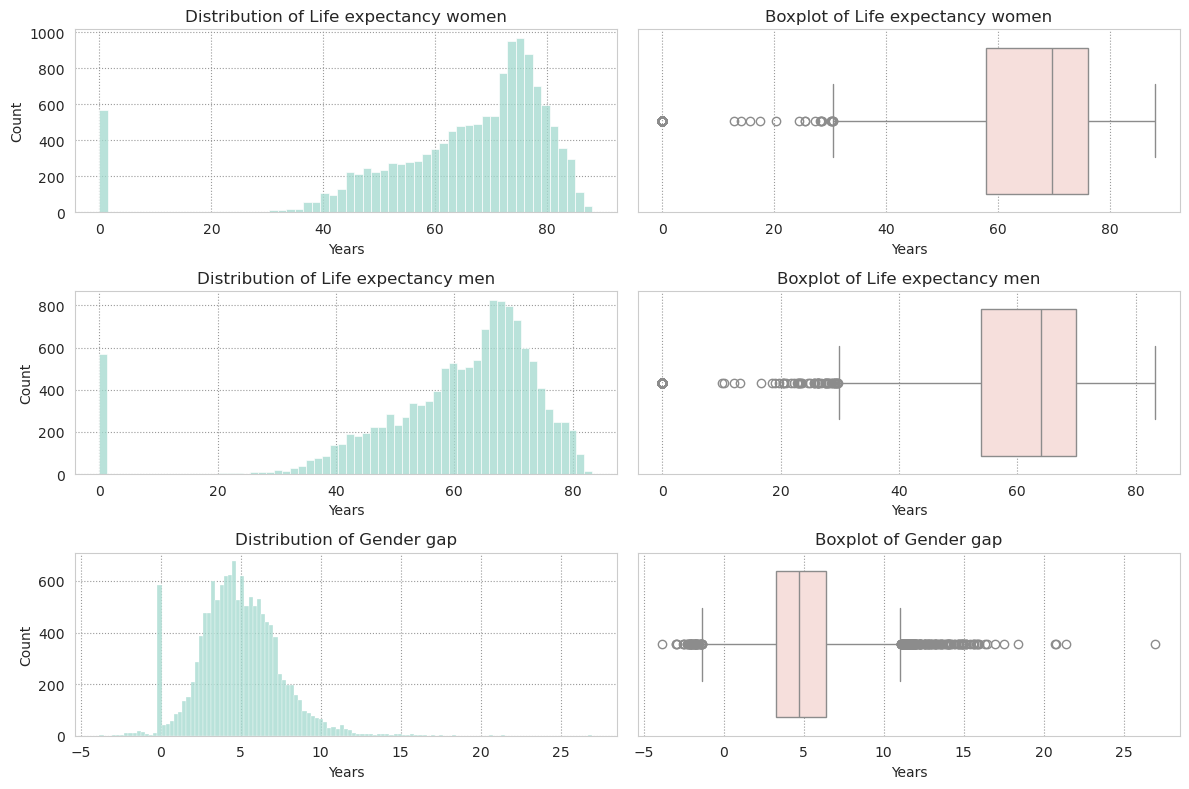

In [39]:
num_columns = ["life_expectancy_women",	"life_expectancy_men",	"gender_gap"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for idx, col in enumerate(num_columns):
	title = col.replace("_", " ").capitalize()
	sns.histplot(
		data=df,
		x=col,
		ax=axes[idx][0],
		color="#a2d9ce"
	)
	axes[idx][0].set_title(f"Distribution of {title}")
	axes[idx][0].set_xlabel("Years")

	sns.boxplot(
		data=df,
		x=col,
		ax=axes[idx][1],
		color="#fadbd8"
	)
	axes[idx][1].set_title(f"Boxplot of {title}")
	axes[idx][1].set_xlabel("Years")

	q_range = float(df[col].quantile(.25).round(2)), float(df[col].quantile(.75).round(2))
	print(f"{title} range: {q_range}")

plt.tight_layout();

**Observations**:
- The average life expectancy for bot males and females is highly concentrated between 50 and 70 years, bases ong the interquartile range (IQR).
- The gender gap in life expectancy (defined as the difference between female and male life expectancy) typically falls betwwen 3 and 7 years, indicating that women consistently live longer than men in most conuntries.

### 5.2 Evolution of Life Expectancy

- How has men and women's life expectancy changed since the 60s?

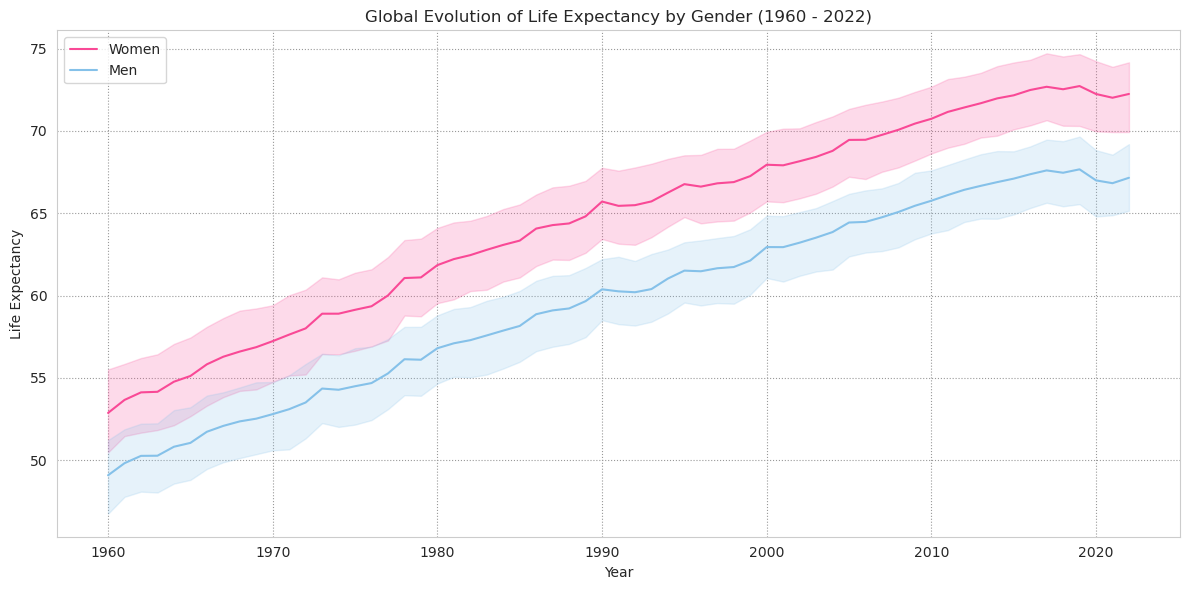

In [40]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="year", y="life_expectancy_women", label="Women", color=gender_colors["Women"])
sns.lineplot(data=df, x="year",y="life_expectancy_men", label="Men", color=gender_colors["Men"])
plt.title("Global Evolution of Life Expectancy by Gender (1960 - 2022)")
plt.ylabel("Life Expectancy")
plt.xlabel("Year")
plt.legend()
plt.tight_layout();

- How has life expectancy changed since the 60s on each region?
- Which regions have the highest growth rate from the 1960 to 2022?

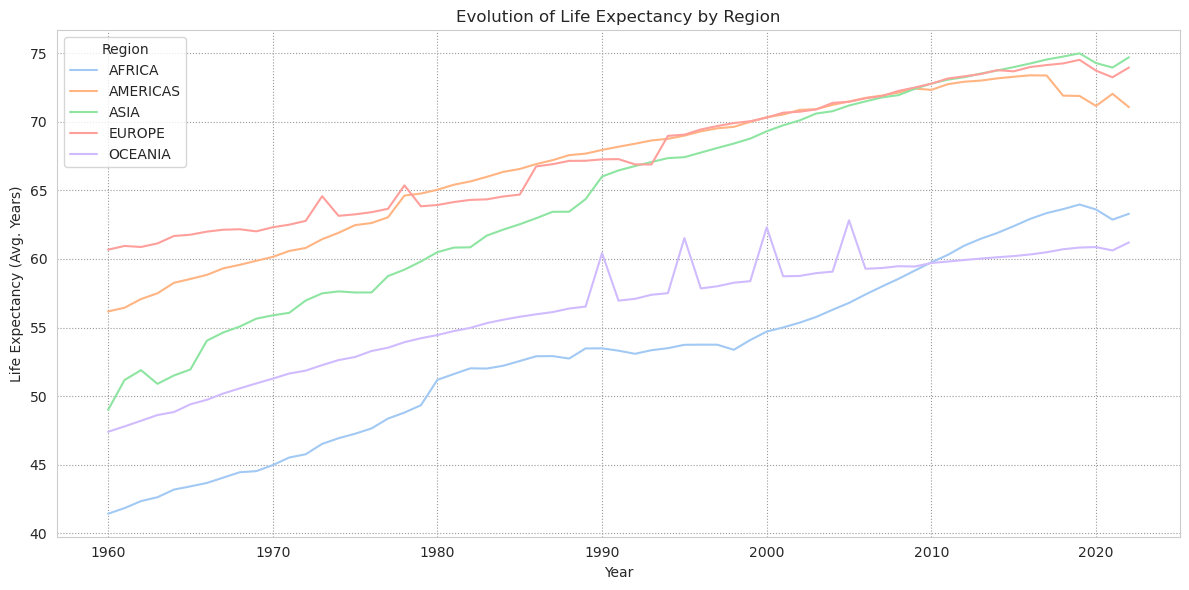

In [41]:
region_le = df.groupby(["region", "year"])[["life_expectancy_avg"]].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=region_le, x="year", y="life_expectancy_avg", hue="region")
plt.title("Evolution of Life Expectancy by Region")
plt.ylabel("Life Expectancy (Avg. Years)")
plt.xlabel("Year")
plt.legend(title="Region")
plt.tight_layout();


In [22]:
df_60_22 = (
	df
	.loc[(df["year"] == 1960) | (df["year"] == 2022)]
	.pivot_table(
		index="region",
		columns="year",
		values="life_expectancy_avg",
		aggfunc="mean"
	)
	.reset_index()
)
df_60_22["total_growth"] = ((df_60_22.iloc[:, 2] - df_60_22.iloc[:, 1]) / df_60_22.iloc[:, 1]) * 100
top_2 = df_60_22[["region", "total_growth"]].nlargest(2, "total_growth")

print("Regions With the Highest Life Expectancy Growth From 1960 to 2022:")
print(f"{top_2.iloc[0, 0].capitalize()} with {top_2.iloc[0, 1]:.2f}% of life expectancy growth.")
print(f"{top_2.iloc[1, 0].capitalize()} with {top_2.iloc[1, 1]:.2f}% of life expectancy growth.")

Regions With the Highest Life Expectancy Growth From 1960 to 2022:
Africa with 52.78% of life expectancy growth.
Asia with 52.49% of life expectancy growth.


### 5.3 Gender Gap

- How is the gender gap per region?

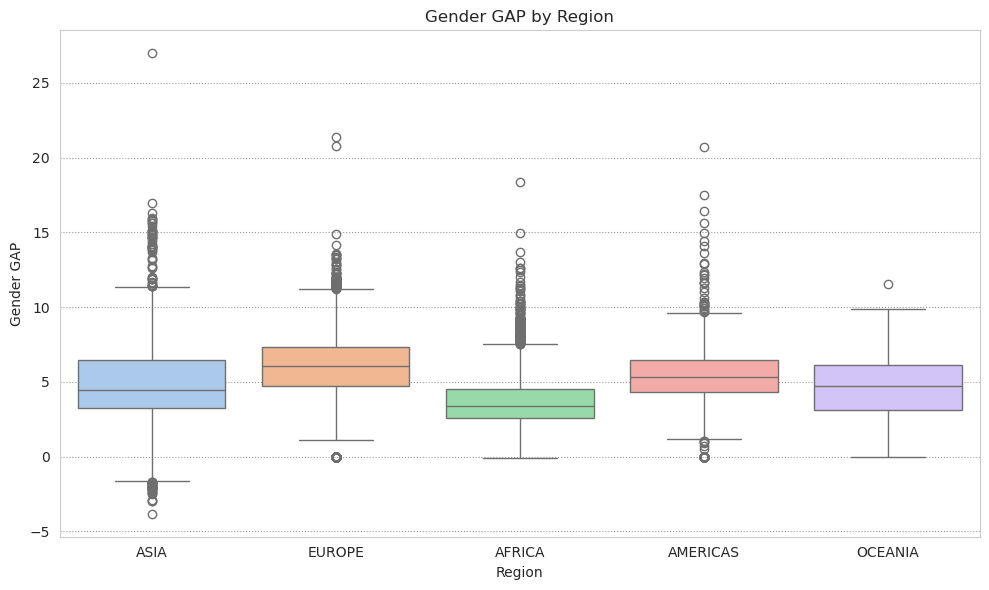

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(
	data=df,
	x="region",
	y="gender_gap",
	palette="pastel"
)

plt.title("Gender GAP by Region")
plt.ylabel("Gender GAP")
plt.xlabel("Region")
plt.tight_layout();

- Has the gender gap decrease or increase over time?
- Which regions and countries have the smallest gender gap in the last year?

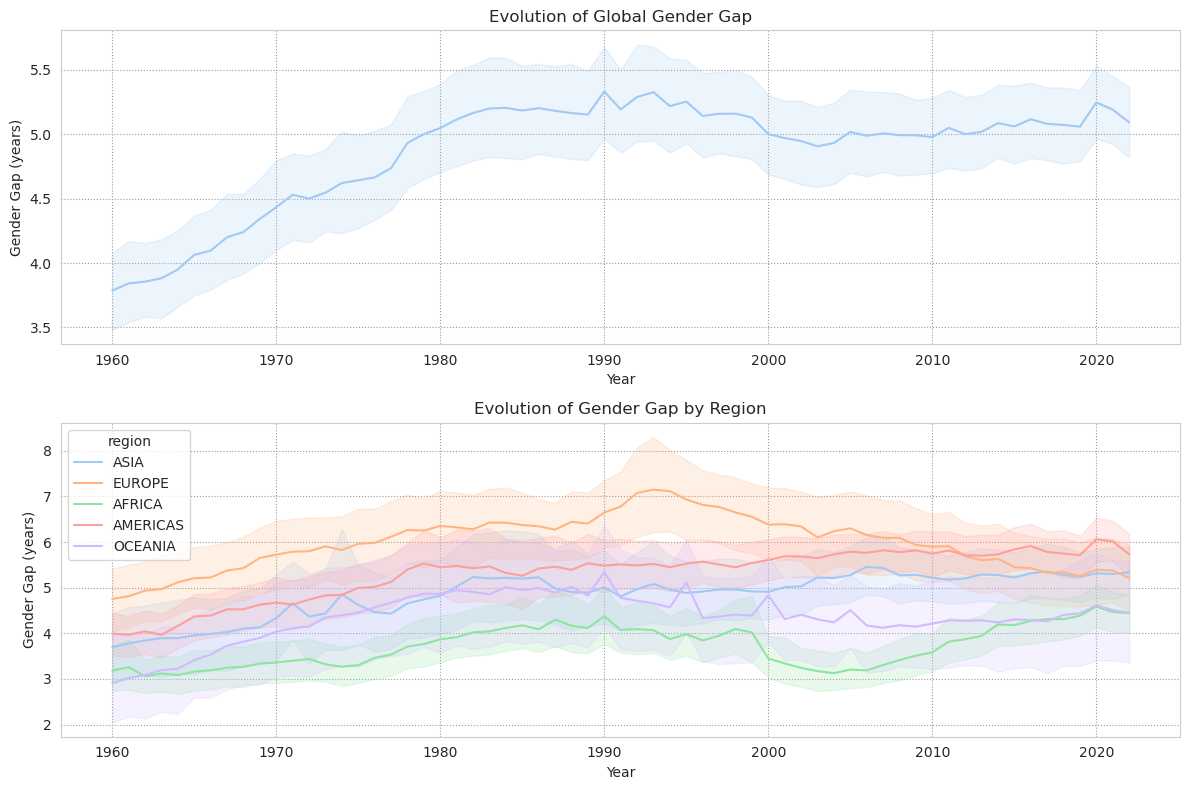

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
sns.lineplot(
	data=df,
	x="year",
	y="gender_gap",
	ax=axes[0]
)
axes[0].set_title("Evolution of Global Gender Gap")
axes[0].set_ylabel("Gender Gap (years)")
axes[0].set_xlabel("Year")


sns.lineplot(
	data=df,
	x="year",
	y="gender_gap",
	hue="region",
	ax=axes[1]
)
axes[1].set_title("Evolution of Gender Gap by Region")
axes[1].set_ylabel("Gender Gap (years)")
axes[1].set_xlabel("Year")
axes[1].set_label("Region")

plt.tight_layout();

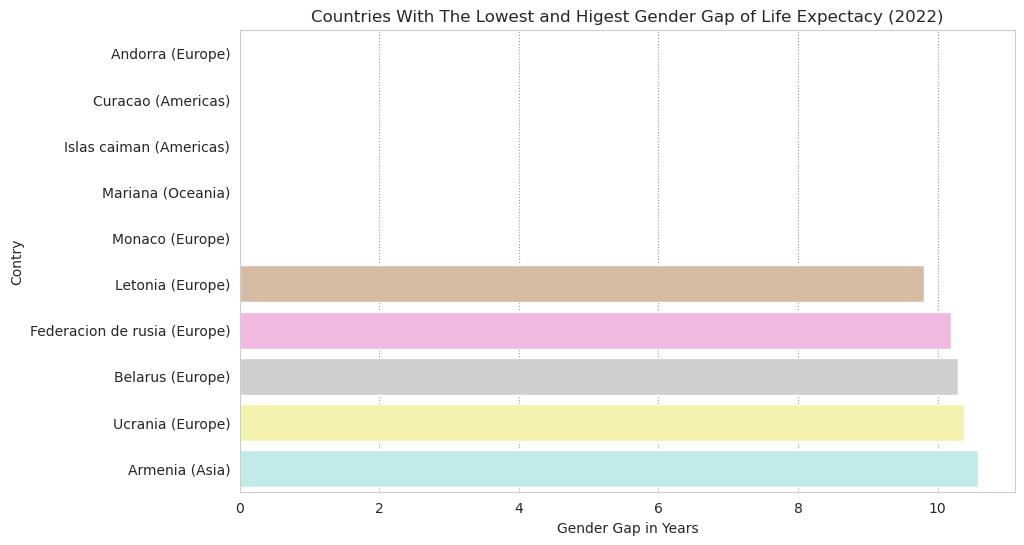

In [47]:
latest_year = df["year"].max()
le_last_year = df.loc[df["year"] == latest_year, ["country_name", "region", "gender_gap"]]

highest_gg = le_last_year.nlargest(5, "gender_gap")
lowest_gg = le_last_year.nsmallest(5, "gender_gap")

highest_lowest = pd.concat([lowest_gg, highest_gg]).sort_values(by="gender_gap")
highest_lowest["country_region"] = highest_lowest["country_name"].str.capitalize() + " (" + highest_lowest["region"].str.capitalize() + ")"

plt.figure(figsize=(10,6))
sns.barplot(
	data=highest_lowest,
	x="gender_gap",
	y="country_region",
	palette="pastel"
)
plt.title(f"Countries With The Lowest and Higest Gender Gap of Life Expectacy ({latest_year})")
plt.xlabel("Gender Gap in Years")
plt.ylabel("Contry");